In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
from torchvision.models import alexnet, AlexNet_Weights
import torchmetrics
from tqdm import tqdm
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Loading Data

In [3]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

test_split, val_split = 0.2, 0.1
train_set = torchvision.datasets.ImageFolder(
    root="./Datasets/QuickDraw_sketches_reduced/",
    transform=train_transform,
)

class_names = train_set.classes
idx_to_class = {value: key for key, value in train_set.class_to_idx.items()}

train_set, test_set = random_split(
    train_set,
    [round(len(train_set) * (1 - test_split)), round(len(train_set) * test_split)],
)
train_set, val_set = random_split(
    train_set,
    [round(len(train_set) * (1 - val_split)), round(len(train_set) * val_split)],
)

batchsize = 64
train_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batchsize, shuffle=False)

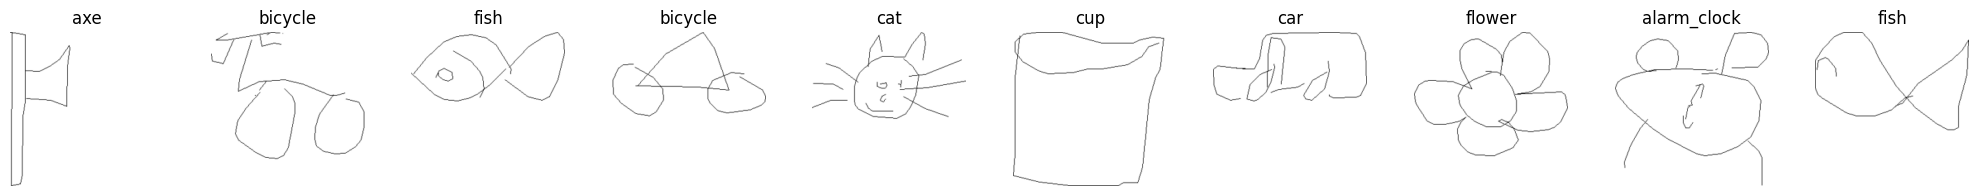

In [4]:
transform_back = transforms.Compose(
    [transforms.Normalize((-1.0, -1, -1), (2.0, 2, 2)), transforms.ToPILImage()]
)
images, labels = next(iter(train_loader))


plt.figure(figsize=(20, 30))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]), cmap="gray")
    plt.axis("off")
    plt.title(idx_to_class[labels[i].item()])
plt.show()

# Model Definition

In [5]:
class AlexNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.alexnet = alexnet(weights=AlexNet_Weights.DEFAULT).features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.fc1 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.alexnet(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


model = AlexNetClassifier(len(class_names))

# Training

In [5]:
def train_loop(model, criterion, optim, epochs, trainloader, testloader, device, num_classes):
    acc_fn = torchmetrics.Accuracy("multiclass", num_classes=num_classes).to(device)
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0

        for (inputs, labels) in tqdm(trainloader, total=len(trainloader)):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optim.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()
            train_loss += loss.item()
            train_acc += acc_fn(outputs, labels).cpu().numpy()
        # validation
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += acc_fn(outputs, labels).cpu().numpy()
        print(
            f"Epoch [{epoch+1}], train loss: {train_loss/len(trainloader)}, val loss: {val_loss/len(testloader)} | train acc: {train_acc/len(trainloader)}, val acc: {val_acc/len(testloader)}"
        )

        train_loss_history += [train_loss / len(trainloader)]
        val_loss_history += [val_loss / len(testloader)]
        train_acc_history += [train_acc / len(trainloader)]
        val_acc_history += [val_acc / len(testloader)]
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [8]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_loop(model, criterion, optim, 20, train_loader, val_loader, device, len(class_names))

100%|██████████| 406/406 [00:35<00:00, 11.33it/s]


Epoch [1], train loss: 1.7774096778754531, val loss: 0.6444132548311482 | train acc: 0.4380644499668347, val acc: 0.8141983695652174


100%|██████████| 406/406 [00:35<00:00, 11.39it/s]


Epoch [2], train loss: 0.682022384822075, val loss: 0.42966404271757475 | train acc: 0.7929794403719784, val acc: 0.8702445652173914


100%|██████████| 406/406 [00:35<00:00, 11.37it/s]


Epoch [3], train loss: 0.5023548876857523, val loss: 0.363897279633776 | train acc: 0.8478978517020277, val acc: 0.8899456521739131


100%|██████████| 406/406 [00:35<00:00, 11.33it/s]


Epoch [4], train loss: 0.42626762210295116, val loss: 0.3271132918763096 | train acc: 0.8709120142636041, val acc: 0.8957201086956522


100%|██████████| 406/406 [00:35<00:00, 11.37it/s]


Epoch [5], train loss: 0.38201989415170523, val loss: 0.30033339327391056 | train acc: 0.8857373768472906, val acc: 0.9099864130434783


100%|██████████| 406/406 [00:35<00:00, 11.32it/s]


Epoch [6], train loss: 0.3467726743426816, val loss: 0.3042808778599188 | train acc: 0.895619526578875, val acc: 0.9086277173913043


100%|██████████| 406/406 [00:35<00:00, 11.31it/s]


Epoch [7], train loss: 0.3273896425228401, val loss: 0.27064565455746403 | train acc: 0.899232861296884, val acc: 0.9201766304347826


100%|██████████| 406/406 [00:35<00:00, 11.44it/s]


Epoch [8], train loss: 0.30817849044068696, val loss: 0.27092804338582505 | train acc: 0.9081314997426395, val acc: 0.9208559782608695


100%|██████████| 406/406 [00:35<00:00, 11.37it/s]


Epoch [9], train loss: 0.28951688778811485, val loss: 0.25379248368351354 | train acc: 0.9141394704433498, val acc: 0.9259510869565217


100%|██████████| 406/406 [00:35<00:00, 11.35it/s]


Epoch [10], train loss: 0.27418246594936646, val loss: 0.2478250531560701 | train acc: 0.9186037561576355, val acc: 0.9293478260869565


100%|██████████| 406/406 [00:35<00:00, 11.39it/s]


Epoch [11], train loss: 0.26056066784879256, val loss: 0.23667929518674297 | train acc: 0.9219861795455951, val acc: 0.9307065217391305


100%|██████████| 406/406 [00:35<00:00, 11.39it/s]


Epoch [12], train loss: 0.25135902960422296, val loss: 0.22907086206681054 | train acc: 0.9263392857142857, val acc: 0.9347826086956522


100%|██████████| 406/406 [00:35<00:00, 11.33it/s]


Epoch [13], train loss: 0.24083145284850901, val loss: 0.23605336564714494 | train acc: 0.927989874126876, val acc: 0.9313858695652174


100%|██████████| 406/406 [00:35<00:00, 11.40it/s]


Epoch [14], train loss: 0.2335730737689974, val loss: 0.22398451876063558 | train acc: 0.9298756499889449, val acc: 0.9354619565217391


100%|██████████| 406/406 [00:35<00:00, 11.34it/s]


Epoch [15], train loss: 0.22574008825083672, val loss: 0.22417751677462744 | train acc: 0.9323044950738916, val acc: 0.9364809782608695


100%|██████████| 406/406 [00:35<00:00, 11.31it/s]


Epoch [16], train loss: 0.21664974532948045, val loss: 0.21888858935436356 | train acc: 0.9349214901477833, val acc: 0.936141304347826


100%|██████████| 406/406 [00:35<00:00, 11.32it/s]


Epoch [17], train loss: 0.21099961215052113, val loss: 0.2151026943212618 | train acc: 0.9371108716638218, val acc: 0.9412364130434783


100%|██████████| 406/406 [00:35<00:00, 11.34it/s]


Epoch [18], train loss: 0.1998477890867318, val loss: 0.22035558845571201 | train acc: 0.939843322402738, val acc: 0.9385190217391305


100%|██████████| 406/406 [00:35<00:00, 11.35it/s]


Epoch [19], train loss: 0.19677678813121002, val loss: 0.21577587912780355 | train acc: 0.9409978790529843, val acc: 0.9385190217391305


100%|██████████| 406/406 [00:35<00:00, 11.28it/s]


Epoch [20], train loss: 0.1940335503371038, val loss: 0.2093243629357818 | train acc: 0.9417248221453774, val acc: 0.9415760869565217


In [9]:
def plot_loss(train_loss_history, val_loss_history):
    plt.plot(train_loss_history, label="train loss")
    plt.plot(val_loss_history, label="val loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
def plot_accuracy(train_acc_history, val_acc_history):
    plt.plot(train_acc_history, label="train acc")
    plt.plot(val_acc_history, label="val acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

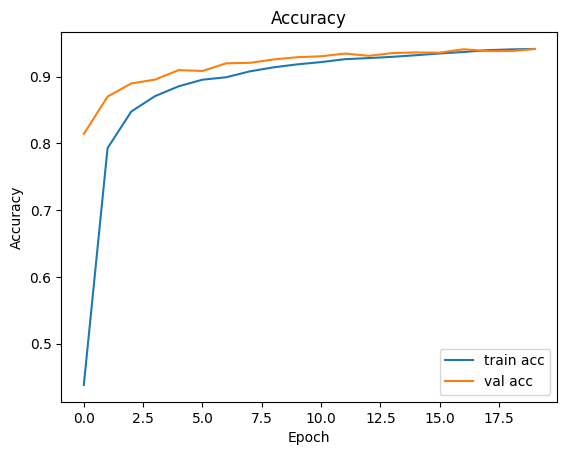

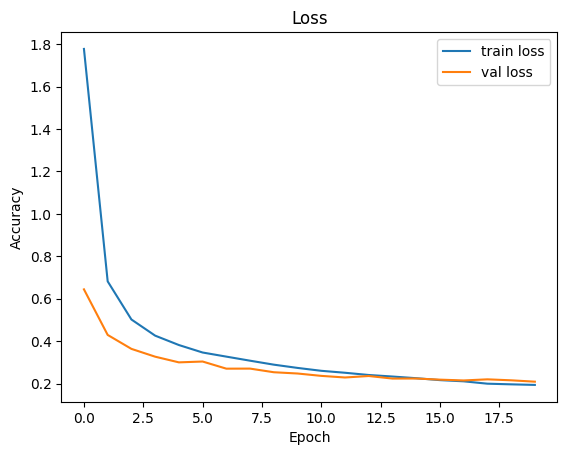

In [10]:
plot_accuracy(train_acc_history, val_acc_history)
plot_loss(train_loss_history, val_loss_history)

# Saving the model

In [2]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "sketch_classifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [ ]:
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\sketch_classifier.pth


# Loading model and testing

In [6]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


def test(model, testloader, device):
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds += predicted.tolist()
            all_labels += labels.tolist()

    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm, display_labels=list(idx_to_class.values())).plot(
        cmap="Blues", xticks_rotation="vertical"
    )
    print(
        classification_report(
            all_labels, all_preds, target_names=list(idx_to_class.values())
        )
    )

In [7]:
model.to(device)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds += predicted.tolist()
        all_labels += labels.tolist()

              precision    recall  f1-score   support

    airplane       0.90      0.97      0.93       624
 alarm_clock       0.94      0.96      0.95       572
         axe       0.95      0.94      0.94       624
     bicycle       0.97      0.98      0.98       623
   butterfly       0.97      0.96      0.97       577
      candle       0.98      0.97      0.98       585
         car       0.95      0.97      0.96       601
         cat       0.94      0.94      0.94       568
         cup       0.98      0.90      0.94       576
        door       0.95      0.98      0.97       647
        fish       0.98      0.93      0.96       599
      flower       0.96      0.96      0.96       606

    accuracy                           0.96      7202
   macro avg       0.96      0.96      0.96      7202
weighted avg       0.96      0.96      0.96      7202



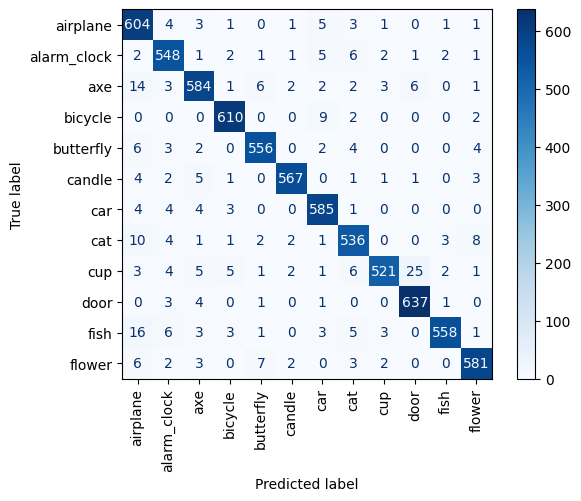

In [ ]:

cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=list(idx_to_class.values())).plot(
    cmap="Blues", xticks_rotation="vertical"
)
print(
    classification_report(
        all_labels, all_preds, target_names=list(idx_to_class.values())
    )
)